In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('data/rfm.csv')
df.describe()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Group,RFM_Score
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,93.041484,91.708689,2053.793018,2.493893,2.509103,2.500115,276.980410,7.503111
std,1721.889758,100.007757,228.792852,8988.248381,1.122159,1.122139,1.118266,118.413054,2.814485
min,12346.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,111.000000,3.000000
25%,13812.500000,18.000000,17.000000,307.245000,1.000000,2.000000,1.500000,144.000000,5.000000
50%,15299.000000,51.000000,41.000000,674.450000,2.000000,3.000000,3.000000,244.000000,8.000000
75%,16778.500000,142.500000,100.000000,1661.640000,3.500000,4.000000,3.500000,377.500000,10.000000
max,18287.000000,374.000000,7847.000000,280206.020000,4.000000,4.000000,4.000000,444.000000,12.000000


In [3]:
df_k = df[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
df_k.set_index('CustomerID', inplace=True)
df_k.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40


In [4]:
df_k.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,93.041484,91.708689,2053.793018
std,100.007757,228.792852,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,307.245000
50%,51.000000,41.000000,674.450000
75%,142.500000,100.000000,1661.640000
max,374.000000,7847.000000,280206.020000


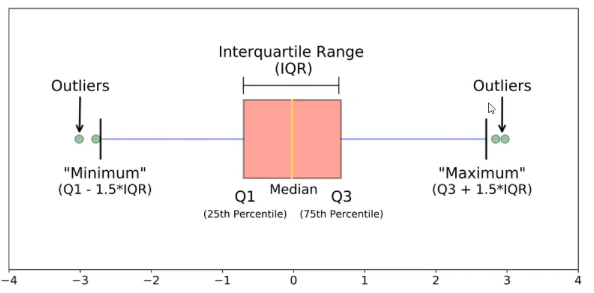

# 이상치 처리

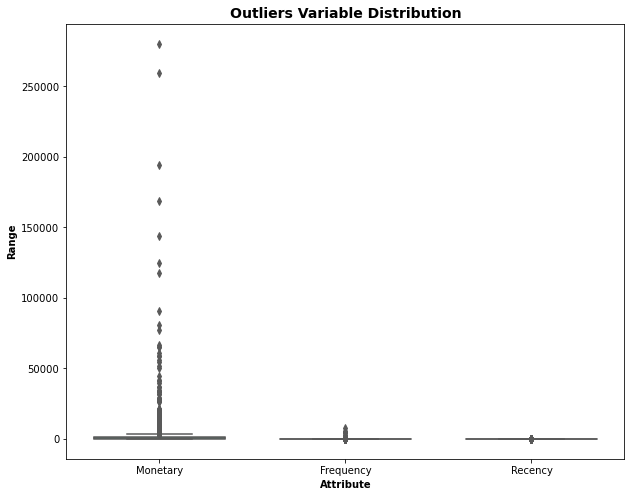

In [5]:
attributes = ['Monetary', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data=df_k[attributes], orient='v', palette='Set2',
           whis=1.5, saturation=1, width=0.7)
plt.title('Outliers Variable Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Range', fontweight='bold')
plt.xlabel('Attribute', fontweight='bold')
plt.show()

In [6]:
# 이상치 제거
for col in df_k.columns:
    q1 = df_k[col].quantile(.25)
    q3 = df_k[col].quantile(.75)
    iqr = q3 - q1
    
    df_k = df_k[(df_k[col] >= q1 - 1.5*iqr) & (df_k[col] <= q3 + 1.5*iqr)]
    
df_k.describe()

,Recency,Frequency,Monetary
count,3504.000000,3504.000000,3504.000000
mean,93.681507,49.218607,778.099878
std,89.936290,45.812070,668.806848
min,1.000000,1.000000,0.000000
25%,23.000000,15.000000,280.375000
50%,59.000000,33.000000,558.510000
75%,149.000000,69.000000,1080.655000
max,327.000000,228.000000,2925.910000


# 스케일링

In [7]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df_k))
scaled_data.columns = df_k.columns
scaled_data.index = df_k.index
scaled_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12348,-0.196628,-0.397738,1.524036
12349,-0.830501,0.519182,1.464683
12350,2.416705,-0.703378,-0.663515
12352,-0.630331,0.781159,2.583985
12353,1.237925,-0.987187,-1.030489


# KMeans

In [8]:
x = list(range(2, 11))

for num_clusters in x:
    kmeans = KMeans(n_clusters=num_clusters,
                    max_iter=300, n_init=10, random_state=1)
    kmeans.fit(scaled_data)
    
    clusters = kmeans.predict(scaled_data)
    
    silhouette_avg = silhouette_score(scaled_data, clusters)
    print(f'n_clusters = {num_clusters} \n  silhoette score : {silhouette_avg:.3f}')

n_clusters = 2 
  silhoette score : 0.422
n_clusters = 3 
  silhoette score : 0.437
n_clusters = 4 
  silhoette score : 0.387
n_clusters = 5 
  silhoette score : 0.387
n_clusters = 6 
  silhoette score : 0.358
n_clusters = 7 
  silhoette score : 0.330
n_clusters = 8 
  silhoette score : 0.337
n_clusters = 9 
  silhoette score : 0.346
n_clusters = 10 
  silhoette score : 0.318


cluster가 3개일 때, 실루엣 계수가 가장 높다.

In [9]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=1)
kmeans.fit_predict(scaled_data)

array([2, 2, 1, ..., 1, 0, 2])

## 엘보우 방법

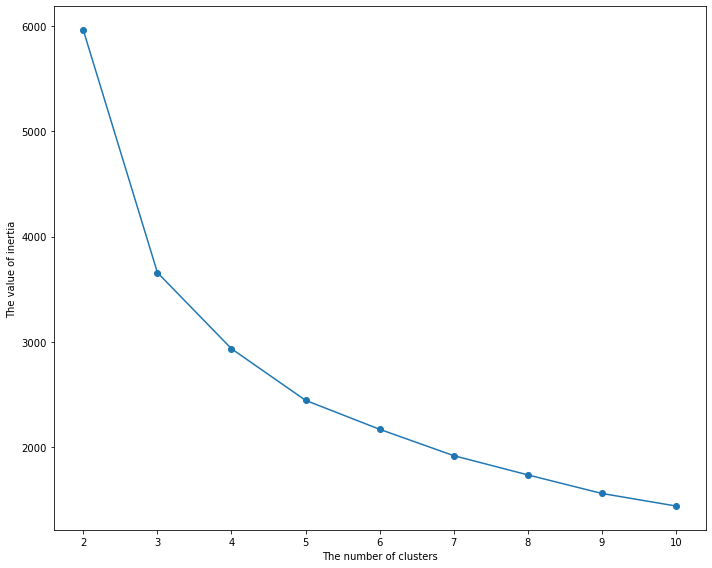

In [10]:
inertia = []

for i in range(2, 11):
    km1 = KMeans(n_clusters=i, n_init=10, max_iter=300, random_state=1)
    km1.fit(scaled_data)
    inertia.append(km1.inertia_)
    
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('The number of clusters')
plt.ylabel('The value of inertia')
plt.tight_layout()
plt.show()

In [11]:
df_k['Cluster'] = kmeans.labels_
df_k.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12348,76,31,1797.24,2
12349,19,73,1757.55,2
12350,311,17,334.40,1
12352,37,85,2506.04,2
12353,205,4,89.00,1


In [12]:
scaled_data['Cluster'] = kmeans.labels_
scaled_data.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12348,-0.196628,-0.397738,1.524036,2
12349,-0.830501,0.519182,1.464683,2
12350,2.416705,-0.703378,-0.663515,1
12352,-0.630331,0.781159,2.583985,2
12353,1.237925,-0.987187,-1.030489,1


## 데이터 추세의 시각화

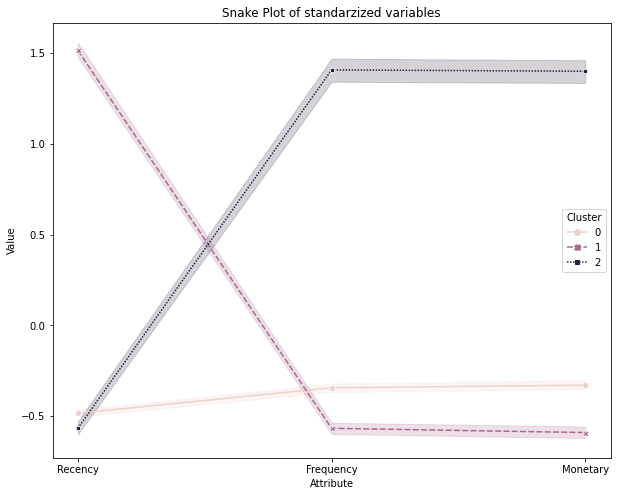

In [13]:
data_melt = pd.melt(scaled_data.reset_index(),
                   id_vars=['Cluster'],
                   value_vars = ['Recency', 'Frequency', 'Monetary'],
                   var_name ='Attribute',
                   value_name='Value')

plt.title('Snake Plot of standarzized variables')
plt.rcParams['figure.figsize'] = [10, 8]
sns.lineplot(x='Attribute', y='Value', hue ='Cluster', style = 'Cluster', markers = True, data = data_melt )
plt.show()

melt : 데이터프레임을 재구조화

- 0번 클러스터
    - R값이 높다 : 최근에 방문하지 않음
    - F값이 낮다 : 자주 방문하지 않음
    - M값이 낮다 : 구매액이 적음
    - 불량 고객군이라고 할 수 있다.
    
- 2번 클러스터
    - R값이 낮다 : 가장 최근에 방문한 집단
    - F값이 높다 : 자주 방문
    - M값이 높다 : 구매액이 크다
    - 우량 고객군이라고 할 수 있다.
    
- 1번 클러스터
    - 최근에 방문했다.
    - 자주 방문한 편이다
    - 신생 고객군이라고 할 수 있다.

In [14]:
df_0 = df_k[df_k['Cluster']==0]
df_1 = df_k[df_k['Cluster']==1]
df_2 = df_k[df_k['Cluster']==2]

In [15]:
df_2.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12348,76,31,1797.24,2
12349,19,73,1757.55,2
12352,37,85,2506.04,2
12356,23,59,2811.43,2
12360,53,129,2662.06,2


In [16]:
df_2.describe()

,Recency,Frequency,Monetary,Cluster
count,800.000000,800.000000,800.000000,800.0
mean,42.788750,113.661250,1713.972763,2.0
std,45.433571,44.453646,620.695770,0.0
min,1.000000,4.000000,360.930000,2.0
25%,11.000000,82.000000,1286.542500,2.0
50%,27.000000,108.000000,1704.605000,2.0
75%,58.000000,141.000000,2182.595000,2.0
max,247.000000,228.000000,2925.910000,2.0


# 과제 : 4개의 클러스터 구성

## 데이터 준비

In [17]:
df = pd.read_csv('data/rfm.csv')
df = df[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
df = df.set_index('CustomerID')

# 이상치 제거
for col in df.columns:
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1
    
    df = df[(df[col] >= q1 - 1.5*iqr) & (df[col] <= q3 + 1.5*iqr)]
    
# 스케일링
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
scaled_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12348,-0.196628,-0.397738,1.524036
12349,-0.830501,0.519182,1.464683
12350,2.416705,-0.703378,-0.663515
12352,-0.630331,0.781159,2.583985
12353,1.237925,-0.987187,-1.030489


## KMeans Clustering

In [18]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=1)
scaled_df['Cluster'] = kmeans.fit_predict(scaled_df)
df['Cluster'] = kmeans.fit_predict(scaled_df)
df.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12348,76,31,1797.24,3
12349,19,73,1757.55,3
12350,311,17,334.40,2
12352,37,85,2506.04,1
12353,205,4,89.00,2


## 추세 시각화

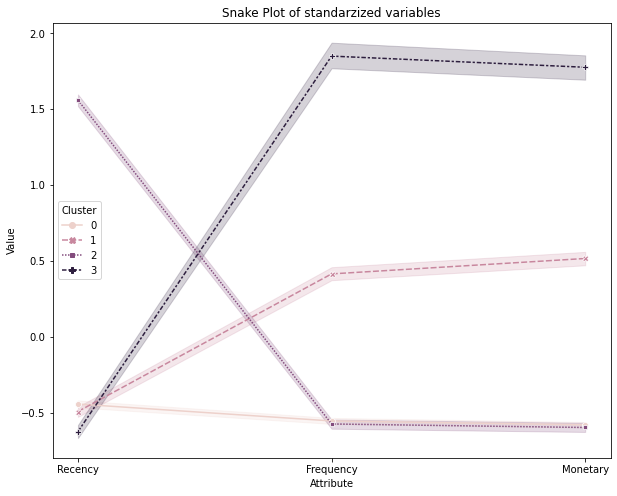

In [19]:
data_melt = pd.melt(scaled_df.reset_index(),
                   id_vars=['Cluster'],
                   value_vars = ['Recency', 'Frequency', 'Monetary'],
                   var_name ='Attribute',
                   value_name='Value')

plt.title('Snake Plot of standarzized variables')
plt.rcParams['figure.figsize'] = [10, 8]
sns.lineplot(x='Attribute', y='Value', hue ='Cluster', style = 'Cluster', markers = True, data = data_melt )
plt.show()

2번 집단은 R값이 높고 F,M값이 낮다. 즉, 최근에 방문하지 않았으며, 기존에 방문 빈도도 낮고 사용 금액도 적었다. 따라서 **과거에 이탈한 고객군**이라고 할 수 있다. 과거에 방문 빈도가 낮았으며 사용 금액도 낮았기 떄문에, 이들이 돌아오도록 마케팅 전략을 펼치고 투자를 하는 것은 큰 효과가 없을 것이라 생각한다.

반대로 3번 집단은 R값이 가장 낮고 F와 M값은 가장 높다. 즉, 가장 최근에 방문했으며 주문 빈도도 높고 사용 금액도 큰 집단이다. 따라서 **우수 고객 또는 핵심 고객 집단**이라고 할 수 있다. 이들이 이탈하지 않도록 마케팅 캠페인을 꾸준히 실행하는 것이 도움이 될 것이다. 

1번 집단은 3번 집단보다는 그 값이 낮지만, 3번 집단 다음으로 우수한 고객 집단이라 할 수 있다. 따라서 이들은 3번 집단으로 향할 수 있도록 소비 촉진을 위한 마케팅 캠페인을 실시한다.

마지막으로 0번 집단은 최근에 방문한 편이지만, F와 M값은 이탈 고객군(2번 집단)과 유사하다. F와 M값이 낮기 때문에 가치가 낮은 집단이라 생각할 수 있지만, 최근에 방문한 것을 생각하면 반대로 **최근에 고객이 된 신규 고객 집단**이라고 해석할 수도 있다. 따라서 **0번 집단의 고객을 우수 고객 집단으로 바꾸기 위해서 이들을 위한 마케팅 캠페인을 실시**하는 것이 유용할 것이다.